In [322]:
import pandas as pd
import copy
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr

# python script available here https://gitlab.com/jericho.mcleod/csi-research/-/blob/main/regress_k.py
import regress_k 

In [324]:
transpose = lambda x: [[x[j][i] for j in range(len(x))] for i in range(len(x[0]))]

def build_cbsa_df(df,cbsa_df):
    idx = df.columns.tolist().index('1/22/20')
    df = copy.deepcopy(df[['FIPS']+df.columns.tolist()[idx:]])
    df['FIPS'] = df['FIPS'].astype(float)
    cbsa_df['FIPS'] = cbsa_df['FIPS'].astype(float)
    cbsa_df = cbsa_df.merge(df,how='left',on='FIPS')
    cbsa_df = cbsa_df.groupby('CBSA').sum()
    cbsa_df = cbsa_df[cbsa_df.columns.tolist()[1:]]
    cbsa_df = cbsa_df.reset_index()
    return cbsa_df

def apply_regr(df,cols_to_skip):
    temp_df = df[df.columns.tolist()[cols_to_skip:]]
    k1,k2,k3 = [],[],[]
    s_temp = []
    for row in temp_df.iterrows():
        y = list(row[1])
        s,i,ks = regress_k.generate_regressions(y,waves=True)
        k1.append(ks[0])
        k2.append(ks[1])
        k3.append(ks[2])
        s_temp.append(s)
    k_df = pd.DataFrame({'K1':k1,'K2':k2,'K3':k3})
    temp_df = df[df.columns.tolist()[:cols_to_skip]]
    out_df = pd.concat([temp_df,k_df],axis=1)
    return out_df, s_temp
    

# Attempt import, if failed, re-build data file
try:
    cbsa_cases_df = pd.read_csv('cbsa_cases_df_export.csv')
    cbsa_deaths_df = pd.read_csv('cbsa_deaths_df_export.csv')
except:
    c = pd.read_csv('~/Documents/csi/csi-research/Data/time_series_covid19_confirmed_US.csv')
    d = pd.read_csv('~/Documents/csi/csi-research/Data/time_series_covid19_deaths_US.csv')
    cbsa = pd.read_csv('~/Documents/csi/csi-research/Data/county-cbsa-crosswalk-cleaned.csv')
    cbsa_crosswalk = copy.deepcopy(cbsa[['County Code','CBSA Code']])
    cbsa_crosswalk.columns = ['FIPS','CBSA']
    cases_df = build_cbsa_df(c,cbsa_crosswalk)
    deaths_df = build_cbsa_df(d,cbsa_crosswalk)
    cbsa_k_cases, cbsa_b1_cases = apply_regr(cases_df,1)
    cbsa_k_deaths, cbsa_b1_deaths = apply_regr(deaths_df,1)
    cbsa_k_cases.columns = ['GTCBSA']+['K'+str(i)+'_cases' for i in range(1,4)]
    cbsa_k_deaths.columns = ['GTCBSA']+['K'+str(i)+'_deaths' for i in range(1,4)]
    cbsa_covid = cbsa_k_cases.merge(cbsa_k_deaths,on='GTCBSA')
    cbsa_data = pd.read_csv('~/Documents/csi/csi-research/Notebooks/CBSA_fpll_tpll.csv')
    cbsa_data = cbsa_data.merge(cbsa_covid,how='right',on='GTCBSA')
    cbsa_b1_cases_df = pd.DataFrame(cbsa_b1_cases)
    cbsa_b1_deaths_df = pd.DataFrame(cbsa_b1_deaths)
    cbsa_b1_cases_df.columns = cases_df.columns.tolist()[1:]
    cbsa_b1_deaths_df.columns = deaths_df.columns.tolist()[1:]
    cbsa_b1_cases_df['GTCBSA'] = cases_df['CBSA']
    cbsa_b1_deaths_df['GTCBSA'] = deaths_df['CBSA']
    cbsa_b1_cases_df = cbsa_b1_cases_df[['GTCBSA']+cbsa_b1_cases_df.columns.tolist()[:-1]]
    cbsa_b1_deaths_df = cbsa_b1_deaths_df[['GTCBSA']+cbsa_b1_deaths_df.columns.tolist()[:-1]]
    cbsa_cases_df = cbsa_data.merge(cbsa_b1_cases_df,on='GTCBSA',how='right')
    cbsa_deaths_df = cbsa_data.merge(cbsa_b1_deaths_df,on='GTCBSA',how='right')

/Users/jericho/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


In [334]:
cbsa_deaths_df.head()

GTCBSA  ALL_fpll    ALL_tpll  SOCIAL_fpll  SOCIAL_tpll  CARE_fpll  \
0   10100       NaN         NaN          NaN          NaN        NaN   
1   10140       NaN         NaN          NaN          NaN        NaN   
2   10180  0.231019  247.230664     0.212377   155.626827   0.048661   
3   10220       NaN         NaN          NaN          NaN        NaN   
4   10260       NaN         NaN          NaN          NaN        NaN   

   CARE_tpll  K1_cases  K2_cases  K3_cases  ...       6/18/21       6/19/21  \
0        NaN  0.204861  0.027668  0.021953  ...  1.469766e-04  1.469766e-04   
1        NaN  0.214707  0.043326       NaN  ...  7.868341e-04  7.868341e-04   
2   9.713526  0.414097  0.020414  0.130096  ...  6.553310e-04  1.616879e-13   
3        NaN  0.171522  0.046909  0.002207  ...  2.077038e-03  2.077038e-03   
4        NaN  0.010873  0.057812  0.020613  ...  9.846458e-22  9.846458e-22   

        6/20/21       6/21/21       6/22/21       6/23/21       6/24/21  \
0  1.469766e-04  1.469766e-04  1.469766e-04  1.469766e-04  1.469766e-04   
1  7.868341e-04  7.868341e-04  7.868341e-04  7.868341e-04  7.868341e-04   
2  1.616879e-13  1.616879e-13  1.616879e-13  1.616879e-13  1.616879e-13   
3  2.077038e-03  2.077038e-03  2.077038e-03  2.077038e-03  2.077038e-03   
4  9.846458e-22  9.846458e-22  9.846458e-22  9.846458e-22  9.846458e-22   

        6/25/21       6/26/21       6/27/21  
0  1.469766e-04  1.469766e-04  1.469766e-04  
1  7.868341e-04  7.868341e-04  7.868341e-04  
2  1.616879e-13  1.616879e-13  1.616879e-13  
3  2.077038e-03  2.077038e-03  2.077038e-03  
4  9.846458e-22  9.846458e-22  9.846458e-22  

[5 rows x 536 columns]

In [326]:
cbsa_pop = pd.read_csv('/Users/jericho/Documents/csi/csi-research/Data/cbsa_pop.csv')
cbsa_pop = cbsa_pop[['GTCBSA','LOG_POP']]
cbsa_pop

GTCBSA   LOG_POP
0     10100  4.631687
1     10140  4.862006
2     10180  5.232155
3     10220  4.583822
4     10300  4.992911
..      ...       ...
933   49660  5.733876
934   49700  5.236711
935   49740  5.321118
936   49780  4.935159
937   49820  4.155458

[938 rows x 2 columns]

In [327]:
cbsa_crosswalk = pd.read_csv('~/Documents/csi/csi-research/Data/county-cbsa-crosswalk-cleaned.csv')
cbsa_crosswalk = cbsa_crosswalk[['County Code','CBSA Code']]
cbsa_crosswalk.columns = ['FIPS','GTCBSA']
elect_county_df = pd.read_csv('/Users/jericho/Documents/csi/csi-research/Data/countypres_2000-2020.csv')
elect_county_df = elect_county_df[elect_county_df['year']==2020]
elect_county_df = elect_county_df[['county_fips','party','candidatevotes']]
elect_county_df = elect_county_df.groupby(['county_fips','party']).sum()
elect_county_df = elect_county_df.reset_index()

dfs = []
parties = elect_county_df['party'].unique().tolist()
for p in parties:
    tdf = elect_county_df[elect_county_df['party']==p]
    tdf = tdf[['county_fips','candidatevotes']]
    tdf.columns = ['FIPS', p+'_VOTES']
    tdf = tdf.fillna(0)
    tdf['FIPS'] = tdf['FIPS'].astype(int)
    dfs.append(tdf)

vote_df = pd.DataFrame({'FIPS':cbsa_crosswalk['FIPS'].tolist()})
for df in dfs:
    vote_df = vote_df.merge(df,on='FIPS',how='left')

vote_df = vote_df.fillna(0)
vote_df = vote_df[vote_df['FIPS']<70000]
vote_df['TOTAL_VOTES'] = vote_df[[i+'_VOTES' for i in parties]].sum(axis=1)
vote_df['FIPS'] = vote_df['FIPS'].astype(int)
vote_df = cbsa_crosswalk.merge(vote_df,on='FIPS')
vote_df = vote_df.groupby('GTCBSA').sum()
vote_df = vote_df[vote_df.columns.tolist()[1:]]
vote_df = vote_df.reset_index()
vote_df

GTCBSA  DEMOCRAT_VOTES  OTHER_VOTES  REPUBLICAN_VOTES  GREEN_VOTES  \
0     10100          6955.0          0.0           12118.0          0.0   
1     10140         17354.0        246.0           19877.0        200.0   
2     10180         16321.0         23.0           51219.0        184.0   
3     10220          4117.0        137.0           10805.0          0.0   
4     10300         20918.0        107.0           31541.0        119.0   
..      ...             ...          ...               ...          ...   
912   49660        123227.0        831.0          151240.0          0.0   
913   49700         28597.0        501.0           42051.0        260.0   
914   49740         32210.0          0.0           36534.0          0.0   
915   49780         11971.0        168.0           27867.0          0.0   
916   49820          1826.0          0.0            2033.0          4.0   

     LIBERTARIAN_VOTES  TOTAL_VOTES  
0                459.0      19532.0  
1                764.0      38441.0  
2                961.0      68708.0  
3                261.0      15320.0  
4                690.0      53375.0  
..                 ...          ...  
912             2623.0     277921.0  
913             1031.0      72440.0  
914             1137.0      69881.0  
915              459.0      40465.0  
916               11.0       3874.0  

[917 rows x 7 columns]

In [344]:
cbsa_data = cbsa_deaths_df[cbsa_deaths_df.columns.tolist()[:13]]
cbsa_deaths = cbsa_deaths_df[['GTCBSA']+cbsa_deaths_df.columns.tolist()[13:]]
cbsa_cases = cbsa_cases_df[['GTCBSA']+cbsa_cases_df.columns.tolist()[13:]]
cbsa_data = cbsa_data.merge(cbsa_pop,on='GTCBSA',how='left')
cbsa_data = cbsa_data.merge(vote_df,on='GTCBSA',how='left')

cbsa_data.to_csv('CBSA_data_f_t_k_vote_pop.csv',index=False)
cbsa_deaths.to_csv('CBSA_deaths.csv',index=False)
cbsa_cases.to_csv('CBSA_cases.csv',index=False)

# Max K plot

In [271]:
# #plt.scatter(cbsa_data['SOCIAL_fpll'], cbsa_data['K2_deaths'])
# #plt.yscale('log')
# #plt.xscale('log')

# labx = ['ALL_fpll', 'ALL_tpll', 'SOCIAL_fpll', 'SOCIAL_tpll',
#        'CARE_fpll', 'CARE_tpll']
# laby = ['K1_cases', 'K2_cases', 'K3_cases',
#        'K1_deaths', 'K2_deaths', 'K3_deaths']

# fig,axes = plt.subplots(6,6,figsize=(24,24))

# for i in range(len(labx)):
#     for j in range(len(laby)):
#         axes[i,j].scatter(cbsa_data[labx[i]], cbsa_data[laby[j]])
#         axes[i,j].set_xlabel(labx[i])
#         axes[i,j].set_ylabel(laby[j])

# plt.tight_layout()
# plt.savefig('family_covid.jpg')

In [328]:
lab_x = ['ALL_fpll', 'SOCIAL_fpll', 'CARE_fpll', 'ALL_tpll', 'SOCIAL_tpll','CARE_tpll']

# df = cbsa_deaths_df

# lab_y = df.columns.tolist()[40:]
# for t in range(len(lab_y)):#lab_y[:10])):
#     fig, axes = plt.subplots(3,2,figsize=(8,8))
#     fig.suptitle(lab_y[t])
#     for i in range(len(lab_x)):
#         x,y = i%3, i//3
#         axes[x,y].scatter(df[lab_x[i]], df[lab_y[t]])
#         axes[x,y].set_xlabel(lab_x[i])
#         axes[x,y].set_ylabel('slope')
#         #axes[x,y].set_ylim(-0.005,0.5)
#         if df[lab_y[t]].max() > 0:
#             axes[x,y].set_yscale('log')

#     plt.tight_layout()
#     temp_string = lab_y[t].split('/')
#     tyear = temp_string[2]
#     tmon = temp_string[0]
#     tday = temp_string[1]
#     if len(tmon) == 1:
#         tmon = '0'+tmon
#     if len(tday) == 1:
#         tday = '0'+tday
#     temp_string = '20'+tyear+tmon+tday
#     plt.savefig('./plots/slopes_t_updated/'+temp_string+'.png')
#     plt.clf()
#     plt.close()

In [ ]:
filenames = os.listdir('./plots/slopes_t_updated/')
filenames = sorted([i for i in filenames if i!= '.DS_Store'])
with imageio.get_writer('./plots/slopes_t_updated/animation.gif', mode='I', duration=0.25) as writer:
    for filename in filenames:
        image = imageio.imread('./plots/slopes_t_updated/'+filename)
        writer.append_data(image)

Use Deaths for K!!!

Compare to (maybe) Nativity and (definitely) K

Rename columns to fgll, tgll: not using p, using g
Do binned plots


When does the effect of f become relevant for Covid?

Mobility data? Facebook data? Need residential to residential mobility
Confounding factors: city to city differences
Explore FB data

wildcard: remember that:
f -> mobility -> time lag -> k

Maybe k-average over some window is a better metric?

Average K for each CBSA with average remaining K to some fixed end date, check against f

In [330]:
cbsa_deaths_df.shape

(929, 536)

[0.0, 0.4948730702274597, 0.06185913377843246]


mean       std  count        ci     upper     lower
bin                                                         
0.0  0.015754  0.013237      4  0.012972  0.028726  0.002782
1.0  0.008311  0.012790     21  0.005470  0.013782  0.002841
2.0  0.004787  0.004896     72  0.001131  0.005918  0.003656
3.0  0.006221  0.004696     95  0.000944  0.007165  0.005277
4.0  0.008167  0.007310     42  0.002211  0.010378  0.005956
5.0  0.011416  0.015793     16  0.007738  0.019154  0.003677
6.0  0.011091  0.013383      7  0.009914  0.021005  0.001177
7.0  0.001271       NaN      1       NaN       NaN       NaN

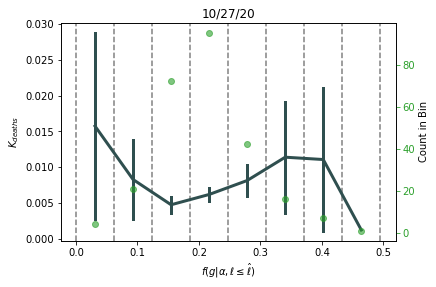

In [ ]:
#fig, ax = plt.subplots()

def make_bin(array, n_bins):
    min_v, max_v = min(array),max(array)
    eps = np.finfo(float).eps
    bins = [np.floor((i-min_v) / (max_v-min_v+eps) * n_bins) for i in array]
    inc = (max_v-min_v)/n_bins
    bin_info = [min_v,max_v,inc]
    return bins, bin_info


def make_ci(df, col, bin):
    ''' Makes confidence intervals
    df: dataframe containing columns col and bin
    col: column to be used for confidence intervals
    bin: column indicating which bin each row belongs to
    '''
    tdf = copy.deepcopy(df[[bin,col]])
    group_df_avg = tdf.groupby(bin).mean()
    group_df_std = tdf.groupby(bin).std()
    group_df_cnt = tdf.groupby(bin).count()
    odf = pd.concat([group_df_avg, group_df_std,group_df_cnt],axis=1)
    odf.columns = ['mean','std','count']
    odf['ci'] = 1.96 * (odf['std']/odf['count']**0.5)
    odf['upper'] = odf['mean']+odf['ci']
    odf['lower'] = odf['mean']-odf['ci']
    return odf
    

def binned_lineplot(ax, df, bin_info,title_info={}):
    bin_centers = []
    upperci = df['upper'].tolist()
    lowerci = df['lower'].tolist()
    ax.axvline(bin_info[1],c='black',alpha=0.5,linestyle='--')
    for i in df.index.tolist():
        ax.axvline(i*bin_info[2]+bin_info[0],c='black',alpha=0.5,linestyle='--')
        bin_centers.append(bin_info[0]+i*bin_info[2] + bin_info[2]/2)
    ax.plot(bin_centers,df['mean'],c='darkslategrey',linewidth=3)
    for i in range(len(bin_centers)):
        ax.plot([bin_centers[i],bin_centers[i]],[lowerci[i],upperci[i]],c='darkslategrey',linewidth=3)
    ax2 = ax.twinx()
    ax2.scatter(bin_centers,df['count'],alpha=0.6,c='tab:green')
    ax2.tick_params(axis='y', colors='tab:green')

    if len(title_info)>0:
        if 'title' in title_info:
            ax.set_title(title_info['title'])
        if 'xlabel' in title_info:
            ax.set_xlabel(title_info['xlabel'])
        if 'ylabel' in title_info:
            ax.set_ylabel(title_info['ylabel'])
            ax2.set_ylabel('Count in Bin')
    return ax


n = 8
bin, info = make_bin(cbsa_deaths_df['ALL_fpll'], n)
cbsa_deaths_df['bin'] = bin
sample_ci_df = make_ci(cbsa_deaths_df,  '10/27/20', 'bin')
print(info)
display(sample_ci_df)

fig, ax = plt.subplots()
ax = binned_lineplot(ax, sample_ci_df, info, title_info={'title':'10/27/20', 'xlabel':r'$f(g | \alpha, \ell \leq \hat{\ell})$', 'ylabel':'$K_{deaths}$'})
plt.show()

In [ ]:
deaths_dates = cbsa_deaths_df.columns.tolist()[13:-1]
col_names = ['ALL_fpll', 'SOCIAL_fpll', 'CARE_fpll', 'ALL_tpll', 'SOCIAL_tpll','CARE_tpll']
lab_x = ['ALL_fgll', 'SOCIAL_fgll', 'CARE_fgll', 'ALL_tgll', 'SOCIAL_tgll','CARE_tgll']
df = cbsa_deaths_df

lab_y = deaths_dates
for t in range(39,len(lab_y)):#lab_y[:10])):
    fig, axes = plt.subplots(3,2,figsize=(8,8))
    fig.suptitle(lab_y[t])
    for i in range(len(lab_x)):
        x,y = i%3, i//3
        bin, info = make_bin(cbsa_deaths_df[col_names[i]].tolist(), n)
        cbsa_deaths_df['bin']=bin
        sample_ci_df = make_ci(cbsa_deaths_df,  deaths_dates[t], 'bin')
        #print(col_names[i])
        #display(sample_ci_df)
        axes[x,y] = binned_lineplot(axes[x,y], sample_ci_df, info, title_info={'xlabel':lab_x[i], 'ylabel':'$K_{deaths}$'})



    plt.tight_layout()
    temp_string = lab_y[t].split('/')
    tyear = temp_string[2]
    tmon = temp_string[0]
    tday = temp_string[1]
    if len(tmon) == 1:
        tmon = '0'+tmon
    if len(tday) == 1:
        tday = '0'+tday
    temp_string = '20'+tyear+tmon+tday
    plt.savefig('./plots/slopes_t_updated2/'+temp_string+'.png', dpi=200)
    plt.clf()
    plt.close()

In [ ]:
filenames = os.listdir('./plots/slopes_t_updated2/')
filenames = sorted([i for i in filenames if i!= '.DS_Store'])
with imageio.get_writer('./plots/slopes_t_updated2/animation.gif', mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread('./plots/slopes_t_updated2/'+filename)
        writer.append_data(image)

In [333]:
perc_native = pd.read_csv('percent_native.csv')
perc_native = perc_native[['CBSA','POP','native']]
perc_native.columns = ['GTCBSA']+perc_native.columns.tolist()[1:]
perc_native.shape

(258, 3)

In [332]:
cbsa_death_native = perc_native.merge(cbsa_deaths_df,on='GTCBSA',how='left')
cbsa_cases_native = perc_native.merge(cbsa_cases_df,on='GTCBSA',how='left')
cbsa_death_native.shape

(258, 538)

8

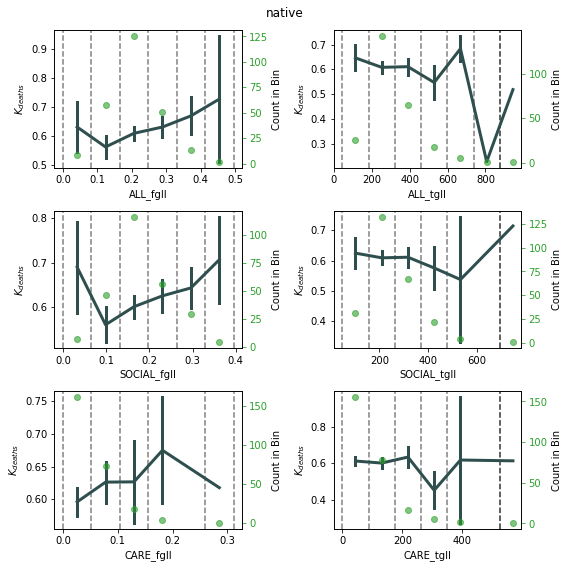

In [27]:
lab_y ='native'
col_names = ['ALL_fpll', 'SOCIAL_fpll', 'CARE_fpll', 'ALL_tpll', 'SOCIAL_tpll','CARE_tpll']
lab_x = ['ALL_fgll', 'SOCIAL_fgll', 'CARE_fgll', 'ALL_tgll', 'SOCIAL_tgll','CARE_tgll']
n = 6

fig, axes = plt.subplots(3,2,figsize=(8,8))
fig.suptitle(lab_y)
for i in range(len(lab_x)):
    x,y = i%3, i//3
    bin, info = make_bin(cbsa_death_native[col_names[i]].tolist(), n)
    cbsa_death_native['bin']=bin
    sample_ci_df = make_ci(cbsa_death_native,  lab_y, 'bin')
    #print(col_names[i])
    #display(sample_ci_df)
    axes[x,y] = binned_lineplot(axes[x,y], sample_ci_df, info, title_info={'xlabel':lab_x[i], 'ylabel':'$K_{deaths}$'})
plt.tight_layout()
plt.show()

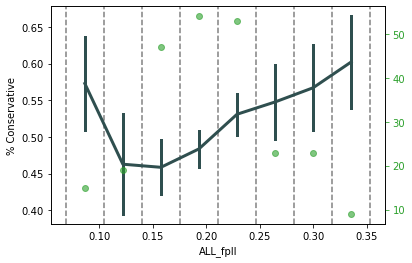

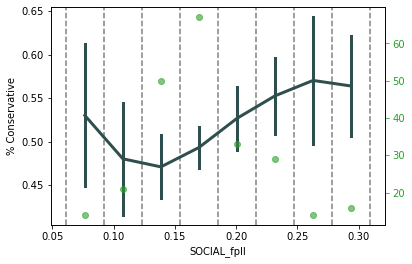

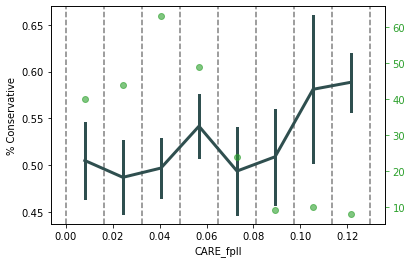

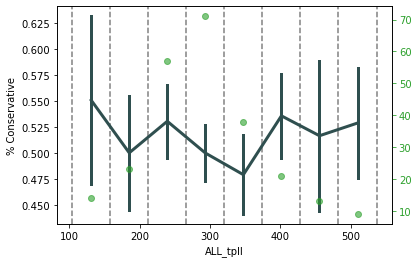

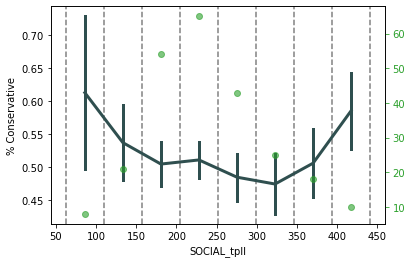

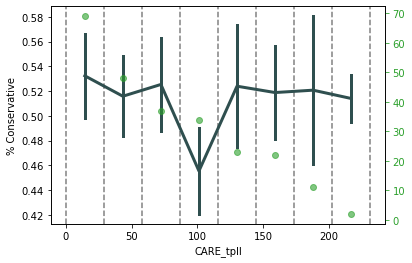

In [113]:

col_names = ['ALL_fpll', 'SOCIAL_fpll', 'CARE_fpll', 'ALL_tpll', 'SOCIAL_tpll','CARE_tpll']

for col in col_names:
    cbsa_data_vote = cbsa_data.merge(vote_df, on='GTCBSA',how='left')
    cbsa_data_vote['percent_conservative'] = cbsa_data_vote['REPUBLICAN_VOTES'] / (cbsa_data_vote['REPUBLICAN_VOTES']+cbsa_data_vote['DEMOCRAT_VOTES'])

    mean = cbsa_data_vote[col].mean()
    stdev = cbsa_data_vote[col].std()
    cbsa_data_vote[col+'_z'] = (cbsa_data_vote[col] - mean) / stdev
    cbsa_data_vote = cbsa_data_vote[cbsa_data_vote[col+'_z'] > -2]
    cbsa_data_vote = cbsa_data_vote[cbsa_data_vote[col+'_z'] < 2]

    bin,info = make_bin(cbsa_data_vote[col].tolist(), 8)
    cbsa_data_vote['bin']=bin
    sample_ci_df = make_ci(cbsa_data_vote,  'percent_conservative', 'bin')
    sample_ci_df = sample_ci_df[sample_ci_df['count']>=2]

    #plt.scatter(cbsa_data_vote[col], cbsa_data_vote['percent_conservative'])

    fig,ax = plt.subplots()
    binned_lineplot(ax, sample_ci_df, info)
    ax.set_xlabel(col)
    ax.set_ylabel('% Conservative')


In [115]:
cbsa_data_vote

GTCBSA  ALL_fpll    ALL_tpll  SOCIAL_fpll  SOCIAL_tpll  CARE_fpll  \
0     10180  0.231019  247.230664     0.212377   155.626827   0.048661   
1     10420  0.248605  515.631881     0.227051   421.508018   0.015763   
2     10580  0.189253  419.491059     0.157915   343.974177   0.032236   
4     10900  0.195679  275.107311     0.143984   250.037770   0.050736   
5     11100  0.266580  455.823540     0.208769   398.966074   0.050612   
..      ...       ...         ...          ...          ...        ...   
253   49180  0.359290  218.102933     0.324430   133.573968   0.125245   
254   49340  0.188134  311.758100     0.152061   288.164918   0.070217   
255   49620  0.246115  359.864893     0.178572   261.668791   0.055659   
256   49660  0.360707  353.734916     0.327637   299.028488   0.093767   
257   49740  0.345677  262.825289     0.286611   274.123956   0.077989   

      CARE_tpll  K1_cases  K2_cases  K3_cases  ...  K3_deaths  DEMOCRAT_VOTES  \
0      9.713526  0.414097  0.020414  0.130096  ...        NaN         16321.0   
1     20.610299  0.290283       NaN  0.030300  ...   0.021769        187329.0   
2    135.583269  0.418238       NaN  0.024764  ...   0.017234        256724.0   
4     65.279753  0.317188  0.004696  0.025658  ...   0.012155        219488.0   
5     10.000000  0.270414       NaN  0.017399  ...   0.013376         23176.0   
..          ...       ...       ...       ...  ...        ...             ...   
253  148.538861  0.212117  0.029533  0.015628  ...   0.011592        151431.0   
254   55.971108  0.495486       NaN  0.020400  ...   0.007676        275479.0   
255  106.544108  0.342167  0.024874  0.031676  ...        NaN         88114.0   
256   71.490507  0.313440       NaN  0.032822  ...   0.020782        123227.0   
257   49.927983  0.237278  0.033470       NaN  ...   0.014276         32210.0   

     OTHER_VOTES  REPUBLICAN_VOTES  GREEN_VOTES  LIBERTARIAN_VOTES  \
0           23.0           51219.0        184.0              961.0   
1         1284.0          170823.0          0.0             3909.0   
2         5610.0          189530.0       2091.0             5481.0   
4          199.0          224866.0        263.0             5255.0   
5           59.0           78347.0        259.0             1413.0   
..           ...               ...          ...                ...   
253       1454.0          204025.0        797.0             3012.0   
254       4813.0          200824.0       2843.0             8044.0   
255          0.0          146733.0          0.0             3624.0   
256        831.0          151240.0          0.0             2623.0   
257          0.0           36534.0          0.0             1137.0   

     TOTAL_VOTES  percent_conservative  CARE_tpll_z  bin  
0        68708.0              0.758351    -0.953550  0.0  
1       363345.0              0.476957    -0.811289  0.0  
2       459436.0              0.424713     0.689718  4.0  
4       450071.0              0.506051    -0.228116  2.0  
5       103254.0              0.771717    -0.949810  0.0  
..           ...                   ...          ...  ...  
253     360719.0              0.573981     0.858857  5.0  
254     492003.0              0.421631    -0.349643  1.0  
255     238471.0              0.624803     0.310603  3.0  
256     277921.0              0.551032    -0.147032  2.0  
257      69881.0              0.531450    -0.428538  1.0  

[247 rows x 22 columns]

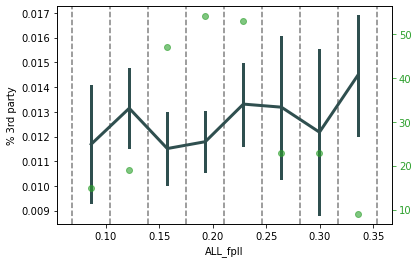

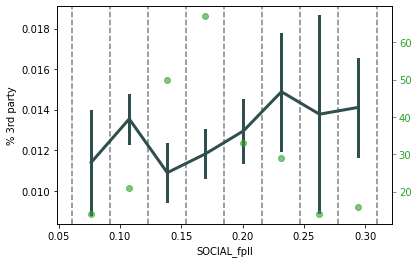

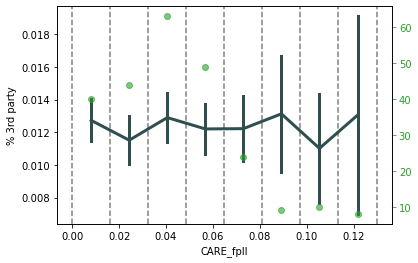

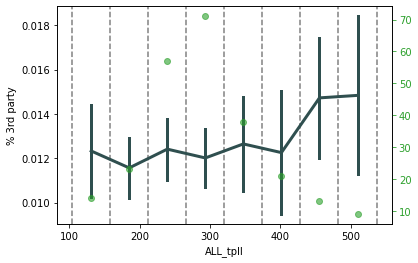

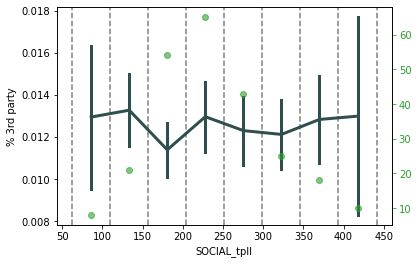

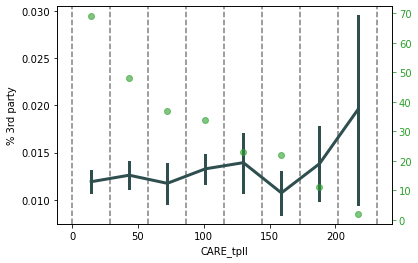

In [122]:

col_names = ['ALL_fpll', 'SOCIAL_fpll', 'CARE_fpll', 'ALL_tpll', 'SOCIAL_tpll','CARE_tpll']

for col in col_names:
    cbsa_data_vote = cbsa_data.merge(vote_df, on='GTCBSA',how='left')
    cbsa_data_vote['percent_3rd_party'] = (cbsa_data_vote['OTHER_VOTES'] + cbsa_data_vote['GREEN_VOTES'] + cbsa_data_vote['LIBERTARIAN_VOTES']) / cbsa_data_vote['TOTAL_VOTES']

    mean = cbsa_data_vote[col].mean()
    stdev = cbsa_data_vote[col].std()
    cbsa_data_vote[col+'_z'] = (cbsa_data_vote[col] - mean) / stdev
    cbsa_data_vote = cbsa_data_vote[cbsa_data_vote[col+'_z'] > -2]
    cbsa_data_vote = cbsa_data_vote[cbsa_data_vote[col+'_z'] < 2]

    bin,info = make_bin(cbsa_data_vote[col].tolist(), 8)
    cbsa_data_vote['bin']=bin
    sample_ci_df = make_ci(cbsa_data_vote,  'percent_3rd_party', 'bin')
    sample_ci_df = sample_ci_df[sample_ci_df['count']>=2]

    #plt.scatter(cbsa_data_vote[col], cbsa_data_vote['percent_conservative'])

    fig,ax = plt.subplots()
    binned_lineplot(ax, sample_ci_df, info)
    ax.set_xlabel(col)
    ax.set_ylabel('% 3rd party')

0.007274490713408278 0.015955403618127185


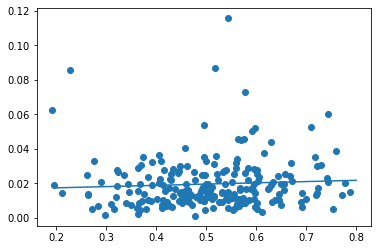

In [164]:
cbsa_data_vote = cbsa_data.merge(vote_df, on='GTCBSA',how='left')
cbsa_data_vote['percent_conservative'] = cbsa_data_vote['REPUBLICAN_VOTES'] / (cbsa_data_vote['REPUBLICAN_VOTES']+cbsa_data_vote['DEMOCRAT_VOTES'])


var = 'K3_deaths'

tdf = cbsa_data_vote[~cbsa_data_vote[var].isna()]
m, b = np.polyfit(tdf['percent_conservative'].tolist(), tdf[var].tolist(), 1)
x = [i/10 for i in range(2,9)]
y = [m*i+b for i in x]

print(m,b)

plt.scatter(cbsa_data_vote['percent_conservative'], cbsa_data_vote[var])
plt.plot(x,y)
#plt.yscale('log')

TODO:
1. Smooth time series, normalize to proporation of average, and make it comparable
2. Convert data files to single flat file
3. Create git repo for this
4. Create relationship matrix for variables (use correlation and mutual informaiton)

5. Seperate data on Blavatnik data for public gatherings or movement restrictions; then look at f and k

In [307]:
temp_vote = copy.deepcopy(cbsa_data_vote)
temp_vote = temp_vote[temp_vote.columns.tolist()[:-1]]
for i in ['DEMOCRAT_VOTES', 'OTHER_VOTES', 'REPUBLICAN_VOTES', 'GREEN_VOTES', 'LIBERTARIAN_VOTES']:
    temp_vote['%_'+i.split('_')[0]] = temp_vote[i] / temp_vote['TOTAL_VOTES']
temp_vote = temp_vote[['GTCBSA']+[i for i in temp_vote.columns.tolist() if '%'==i[0]]]
    
cases_output = cbsa_cases_native
death_output = cbsa_death_native

cases_output = temp_vote.merge(cases_output,how='left',on='GTCBSA')
death_output = temp_vote.merge(death_output,how='left',on='GTCBSA')

death_output.shape

(258, 543)

In [313]:
death_output.columns.tolist()[0:20]

cbsa_output = death_output[death_output.columns.tolist()[0:20]]
cbsa_output.to_csv('CBSA_dataset_f_t_k_nat_vote.csv', index=False)

death_output[['GTCBSA']+death_output.columns.tolist()[20:]].to_csv('CBSA_deaths.csv', index=False)
cases_output[['GTCBSA']+cases_output.columns.tolist()[20:]].to_csv('CBSA_cases.csv', index=False)

# Mutual Information and Correlation Matrices

In [260]:
temp_nat = cbsa_death_native
temp_nat = temp_nat[['GTCBSA','native']]
temp_vote = copy.deepcopy(cbsa_data_vote)
temp_vote = temp_vote[temp_vote.columns.tolist()[:-1]]
for i in ['DEMOCRAT_VOTES', 'OTHER_VOTES', 'REPUBLICAN_VOTES', 'GREEN_VOTES', 'LIBERTARIAN_VOTES']:
    temp_vote['%_'+i.split('_')[0]] = temp_vote[i] / temp_vote['TOTAL_VOTES']
temp_pop_nat = cbsa_pop.merge(temp_nat,on='GTCBSA',how='left')
temp_vote = temp_pop_nat.merge(temp_vote,on='GTCBSA',how='left')

cols = temp_vote.columns.tolist()[1:]
skip = ['DEMOCRAT_VOTES', 'OTHER_VOTES', 'REPUBLICAN_VOTES', 'GREEN_VOTES', 'LIBERTARIAN_VOTES']
cols = [i for i in cols if i not in skip+['TOTAL_VOTES']]

In [254]:
mi_df = pd.DataFrame({'Variable':cols})
for i in cols:
    vals = []
    for j in cols:
        if i!=j:
            temp_df = temp_vote[[i,j]]
            tdf = copy.deepcopy(temp_df)
            temp_df = temp_df[~temp_df[i].isna()]
            temp_df = temp_df[~temp_df[j].isna()]
            mi = mutual_info_regression(np.array(temp_df[i]).reshape(-1,1), temp_df[j])
            #mi = mutual_info_regression(cbsa_data_vote[i], cbsa_data_vote[j])
            vals.append(mi[0])
        if i==j:
            vals.append(np.nan)
    mi_df[i] = vals

mi_df.index = mi_df['Variable']
mi_df = mi_df[mi_df.columns.tolist()[1:]]
mi_df

print('Mutual Information Matrix')
mi_df.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '12px'})

Mutual Information Matrix


In [255]:


pearson_df = pd.DataFrame({'Variable':cols})
for i in cols:
    vals = []
    for j in cols:
        if i!=j:
            tdf = copy.deepcopy(temp_df)
            temp_df = temp_vote[[i,j]]
            temp_df = temp_df[~temp_df[i].isna()]
            temp_df = temp_df[~temp_df[j].isna()]
            pr = pearsonr(temp_df[i], temp_df[j])
            #mi = mutual_info_regression(cbsa_data_vote[i], cbsa_data_vote[j])
            vals.append(pr[0])
        if i==j:
            vals.append(np.nan)
    pearson_df[i] = vals

pearson_df.index = pearson_df['Variable']
pearson_df = pearson_df[pearson_df.columns.tolist()[1:]]
pearson_df

print('Pearson\'s Correlation Matrix')
pearson_df.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '12px'})

Pearson's Correlation Matrix


In [259]:

import time

spearman_df = pd.DataFrame({'Variable':cols})
t1 = time.time()
c = 0
for i in cols:
    vals = []
    for j in cols:
        if i!=j:
            c +=1
            tdf = copy.deepcopy(temp_df)
            temp_df = temp_vote[[i,j]]
            temp_df = temp_df[~temp_df[i].isna()]
            temp_df = temp_df[~temp_df[j].isna()]
            pr = spearmanr(temp_df[i], temp_df[j])
            #mi = mutual_info_regression(cbsa_data_vote[i], cbsa_data_vote[j])
            vals.append(pr[0])
        if i==j:
            vals.append(np.nan)
    spearman_df[i] = vals
t2 = time.time()
print(t2-t1, c)

spearman_df.index = spearman_df['Variable']
spearman_df = spearman_df[spearman_df.columns.tolist()[1:]]
spearman_df

print('Spearman\'s Correlation Matrix')
spearman_df.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '12px'})

0.34322500228881836 342
Spearman's Correlation Matrix
